In [14]:
import argparse

from utils import (print_yaml_config,init_or_resume_from, read_yaml)
from model_training.training_utils import load_for_inference
from constants import TOKENIZER_SEPECIAL_TOKENS
from training_datasets.dataset_utils import load_rm_dataset

config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["eval_ranking_rm"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "eval_ranking_rm"

# Create a Namespace object for config
config_ranking = argparse.Namespace(**config)

config = {}
config.update(conf["default"])
config.update(conf["eval_abs_rm"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "eval_abs_rm"

# Create a Namespace object for config
config_abs = argparse.Namespace(**config)
 
config_abs.dataset["oasst_export_abs"]["label_weight"] = {"violence": 0, "creativity": 0, "helpfulness": 0, "humor": 0, "toxicity": 0,"quality": 1}
config_abs.dataset["oasst_export_abs"]["abs_oversample_threshold"]=None#0.4
config_abs.dataset["oasst_export_abs"]["top_k"]=None
# v3_wgt = {"violence": 0, "creativity": 0.15, "helpfulness": 0.35, "humor": 0, "toxicity": -0.1,"quality": 0.4}
# qlty = {"violence": 0, "creativity": 0, "helpfulness": 0, "humor": 0, "toxicity": 0,"quality": 1}
# mean = {"violence": -0.167, "creativity": 0.167, "helpfulness": 0.167, "humor": 0.167, "toxicity": -0.167,"quality": 0.165}
# v4_wgt = {"violence": -0.1, "creativity": 0.2, "helpfulness": 0.1, "humor": 0.167, "toxicity": -0.1,"quality": 0.3}
# v2_wgt = {"violence": -0.05, "creativity": 0.15, "helpfulness": 0.25, "humor": 0.05, "toxicity": -0.1, "quality": 0.4
# }



# v3
# non violence: 0
# creativity: 0.15
# helpfulness: 0.35
# humor: 0
# non toxicity: 0.1
# quality: 0.4
        
# v2
# non violence: 0.05
# creativity: 0.15
# helpfulness: 0.25
# humor: 0.05
# non toxicity: 0.1
# quality: 0.4
# only qualiyt
# non violence: 0
# creativity: 0
# helpfulness: 0
# humor: 0
# non toxicity: 0
# quality: 1
# mean
# non violence: 0.167
# creativity: 0.167
# helpfulness: 0.167
# humor: 0.167
# non toxicity: 0.167
# quality: 0.165


config_abs.dataset["oasst_export_abs"]["top_k"]=None

"""Quality: Since quality directly pertains to how good, informative, and comprehensive the answer is, it should have the highest weight.

Weight: 0.4
Helpfulness: An answer's primary goal, especially in this context, is to be helpful. If it's not helping the user understand or solve a problem, its value diminishes.

Weight: 0.25
Creativity: While creativity might not be as crucial as quality or helpfulness, a creative response can provide more insight or a fresh perspective.

Weight: 0.15
Toxicity: It's vital to ensure responses are not toxic. However, since the provided responses were largely non-toxic, this label might not need a very high weight. Still, it's essential to consider it.

Weight: 0.1 (This would work in a negative fashion, where higher toxicity reduces the overall score.)
Violence: Similar to toxicity, ensuring non-violence is crucial. Since the given responses didn't exhibit violence, this can have a smaller weight.

Weight: 0.05 (Again, this would work negatively.)
Humor: While humor can be a bonus, it's not necessarily a priority in this context. Therefore, it should have the lowest weight.

Weight: 0.05

"""


# """
# Given the clarified requirements and the focus on ensuring that the scalar reward reflects the desired properties of helpfulness, harmlessness, quality, and entertainment, let's proceed.

# Non-violence & Non-toxicity (After Subtracting from 1): Since higher values are now desirable, and the majority of the data is skewed toward these values, these metrics will dominate the scalar reward if given too much weight. While harmlessness is a priority, we don't want it overshadowing helpfulness.

# Helpfulness: This is a core metric. The response must be helpful for a general-purpose chatbot, so this should carry a significant weight. However, we don't want a harmless but unhelpful response to get a high reward.

# Quality: This essentially determines the coherence, relevance, and overall acceptability of the response. It's a fundamental metric.

# Creativity & Humor: Both these metrics add to the entertaining aspect. Humor might not always be relevant in every context, so while it should have a weight, it shouldn't be too high. Creativity, on the other hand, could be desirable more often as it can provide unique and insightful responses.

# Based on the above considerations, here's a suggested distribution:

# Non-violence: 0.20
# Non-toxicity: 0.20
# Helpfulness: 0.30
# Quality: 0.20
# Creativity: 0.05
# Humor: 0.05
# This distribution sums up to 1. The logic here is:

# Harmlessness (Non-violence and Non-toxicity) collectively gets a weight of 0.40. This ensures the chatbot doesn't produce harmful content.
# Helpfulness is given a significant weight (0.30) so that utility is prioritized.
# Quality is given an equal weight as harmlessness metrics because for a general-purpose chatbot, the quality of response matters.
# Entertainment (Creativity and Humor) gets a collective weight of 0.10, ensuring the chatbot can be engaging but without compromising on the core objectives.
# This distribution aims to balance the objectives laid out and mitigate the effects of the skewness in the data for non-violence and non-toxicity.
# """



train_e , eval_abs = load_rm_dataset(config_abs)

# train_er , eval_ranking = load_rm_dataset(config_ranking)


===loading the oasst_export_abs dataset===

{'violence': 0, 'creativity': 0, 'helpfulness': 0, 'humor': 0, 'toxicity': 0, 'quality': 1}
============================== total 774 has None value for atleast 1 label
============================== total 0 has been skipped because reward is negative
{'violence': 0, 'creativity': 0, 'helpfulness': 0, 'humor': 0, 'toxicity': 0, 'quality': 1}
============================== total 32 has None value for atleast 1 label
============================== total 0 has been skipped because reward is negative
OASST HF dataset: len(train)=38852, len(val)=2041
Size of oasst_export_abs training data: 38852
Size of oasst_export_abs validation data: 2041
============================== Total training dataset size is 38852...
	============================== Validation size for oasst_export_abs dataset size is 2041...


In [19]:
len([ss for ss in s if ss <= 0.4 ]) #38852/3354

4104

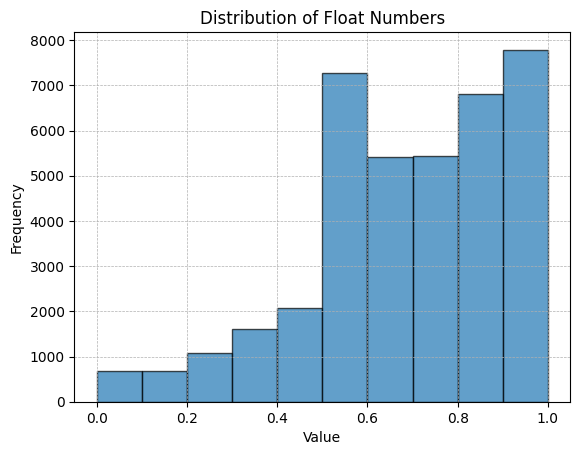

In [18]:
s = []

for e in train_e:
    prefix, reply, score = e
    s.append(score)

# for e in eval_abs["oasst_export_abs"]:
#     prefix, reply, score = e
#     s.append(score)

import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(s, bins=10, edgecolor="k", alpha=0.7)
plt.title("Distribution of Float Numbers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [1]:
import transformers
import torch
from transformers import BitsAndBytesConfig
from peft import PeftModel

model_args = {
    "torch_dtype": torch.bfloat16,
    # "quantization_config": BitsAndBytesConfig(
    #     load_in_4bit=True,
    #     bnb_4bit_quant_type="nf4",
    #     bnb_4bit_compute_dtype=torch.bfloat16,
    #     bnb_4bit_use_double_quant=True,
    #     ),
    "cache_dir": 'cache',
    "device_map": {"":1},
}

model_name = 'output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1/merged/'

# abs_adapter_mean_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64/final_checkpoint"
# abs_adapter_wavg_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg/final_checkpoint"
# # abs_adapter2_wavg_l2_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_l2_1e-5/final_checkpoint"
# abs_adapter3_wavg_l2_no_sig_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_l2_1e-5_no_sigmoid/final_checkpoint"
# abs_adapter3_wavg_no_sig_os_at05_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v2_no_sig_oversampled_at05_wgt_loss/final_checkpoint"

# abs_adapter4_wavg_no_sig_os_at05_wgt_loss_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v3_no_sig_oversampled_at05_wgt_loss/final_checkpoint"
# abs_adapter4_wavg_no_sig_os_at05_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v3_no_sig_oversampled_at05/final_checkpoint"


# # abs_adapter4_no_sig_v2_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v2_l2_1e-5_no_sigmoid/final_checkpoint"
# abs_adapter5_no_sig_v3_oversampled ="output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v3_no_sigmoid_oversampled/final_checkpoint"
# abs_adapter5_no_sig_v3_d02 ="output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v3_no_sigmoid_wgt_loss_115_d_0.2/final_checkpoint"

# # abs_adapter = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_test_replication/final_checkpoint"
# ranking_adapter_name= "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16/final_checkpoint"
# ranking_adapter_name2 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16_top_1/final_checkpoint"


# abs_mean = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_mean_oversampled/final_checkpoint"
# abs_v2_wgt = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v2_wgt_oversampled/final_checkpoint"
# abs_v3_wgt = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v3_wgt_oversampled/final_checkpoint"
# abs_only_quality = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_only_quality_oversampled/final_checkpoint"
# rank_top_1 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16_top_1/final_checkpoint"
# abs_v32_wgt_loss = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v32_wgt_oversampled_wgt_loss_0.75_capacity/final_checkpoint"
# abs_v32_wgt = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v32_wgt_oversampled/final_checkpoint"
# abs_v32_wgt_ep1 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_64_ep_1/final_checkpoint"

abs_adapter_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_64_ep_1/final_checkpoint"
abs_adapter_name2 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_128_ep_1_logistic/final_checkpoint"
abs_adapter_name3 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_128_ep_1_logistic_wgt_loss/final_checkpoint"

ranking_adapter_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16_top_1/final_checkpoint"
ranking_adapter_name2 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs_64_ep_1/final_checkpoint"

# Since reward models are trained using the same base model, we should use same model
base_reward_model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=1,**model_args
    )
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, cache_dir='cache')


base_reward_model = PeftModel.from_pretrained(
    base_reward_model,
    ranking_adapter_name2,
    adapter_name="rank_ep1",
    is_trainable=False
    )
# base_reward_model.load_adapter(ranking_adapter_name2,adapter_name="rank_ep1",is_trainable=False)

# base_reward_model.load_adapter(abs_adapter_name,adapter_name="abs",is_trainable=False)
base_reward_model.load_adapter(abs_adapter_name2,adapter_name="abs_logistic",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter_name3,adapter_name="abs_logistic_wgt",is_trainable=False)

# base_reward_model.load_adapter(abs_v2_wgt,adapter_name="abs_v2_wgt",is_trainable=False)
# base_reward_model.load_adapter(abs_v3_wgt,adapter_name="abs_v3_wgt",is_trainable=False)
# base_reward_model.load_adapter(abs_only_quality,adapter_name="abs_only_quality",is_trainable=False)
# base_reward_model.load_adapter(rank_top_1,adapter_name="rank_top_1",is_trainable=False)
# base_reward_model.load_adapter(abs_v32_wgt_loss,adapter_name="abs_v32_wgt_loss",is_trainable=False)
# base_reward_model.load_adapter(abs_v32_wgt,adapter_name="abs_v32_wgt",is_trainable=False)
# base_reward_model.load_adapter(abs_v32_wgt_ep1,adapter_name="abs_v32_wgt_ep1",is_trainable=False)

[2023-11-15 09:27:59,852] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1/merged/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.v_proj.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.o_proj.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.rank_ep1.weight', 'base_model.model.model.layers.0.mlp.gate_proj.weight', 'base_model.model.model.layers

In [2]:
base_reward_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (rank_ep1): Dropout(p=0.1, inplace=False)
                  (abs_logistic): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (rank_ep1): Linear(in_features=4096, out_features=64, bias=False)
                  (abs_logistic): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (rank_ep1): Linear(in_features=64, out_features=4096, bias=False)
                  (abs_logistic): Linear(in_features=64, o

In [3]:
from training_datasets.collators import AbsoluteScoreDataCollator, RankingDataCollator


abs_collate_fn = AbsoluteScoreDataCollator(
    tokenizer,
    max_length=2048,
    pad_to_multiple_of=16,
)

ranking_collate_fn = RankingDataCollator(
    tokenizer,
    max_length=2048,
    pad_to_multiple_of=16,
    max_replies=4#config_ranking.max_replies
)

# eval_abs,eval_ranking

In [8]:
base_reward_model.active_adapter


'abs_logistic'

In [24]:
data = eval_abs["oasst_export_abs"]

l_50 = []
p_50 = []

l = []
p = []

base_reward_model.set_adapter("abs_logistic")
for d in data:
    inputs = abs_collate_fn([d])
    labels = inputs.pop("labels")
    inputs = inputs.to(base_reward_model.device)
    logits = base_reward_model(input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                use_cache=False,
                ).logits
    if labels <= 0.4:
        l_50.append(labels)
        p_50.append(logits[0])
    else:
        l.append(labels)
        p.append(logits[0])


In [33]:
sigmoid = torch.nn.Sigmoid()

l_50[54:60], p_50[54:60],sigmoid(p_50[54:60])

(tensor([0.1000, 0.3875, 0.1594, 0.2708, 0.3083, 0.3458], dtype=torch.float64),
 tensor([-1.1328, -0.1260, -1.4531, -1.0703, -0.5039, -1.6328],
        dtype=torch.bfloat16),
 tensor([0.2432, 0.4688, 0.1895, 0.2559, 0.3770, 0.1631], dtype=torch.bfloat16))

In [25]:
sigmoid = torch.nn.Sigmoid()

from sklearn.metrics import mean_squared_error, mean_absolute_error

def abs_reward_metrics(predictions,labels):
    predictions = sigmoid(predictions)
    predictions = [p.float() if p.dtype == torch.bfloat16 else p for p in predictions]
    labels = [l.float() if l.dtype == torch.bfloat16 else l for l in labels]


    return {
        'mse': mean_squared_error(labels, predictions),
        'mae': mean_absolute_error(labels, predictions)
    }


In [34]:
import torch
l_50 = torch.tensor(l_50)
p_50 = torch.tensor(p_50)


l = torch.tensor(l)
p = torch.tensor(p)

print(abs_reward_metrics(p_50,l_50))
print(abs_reward_metrics(p,l))

## from for bit logitstic sigmoid + wgt loss
# {'mse': 0.04753870369349233, 'mae': 0.17926979778653887}
# {'mse': 0.027010542591441575, 'mae': 0.13228511980761412}

## from 4 bit logistic sigmoid
# {'mse': 0.05205766017335934, 'mae': 0.19300111204519685}
#  {'mse': 0.02084478758192499, 'mae': 0.11781447598714637}

{'mse': 0.025611386407787512, 'mae': 0.12173174989692846}
{'mse': 0.05307156072948854, 'mae': 0.1999579205688052}


/tmp/ipykernel_1344905/2652289913.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_50 = torch.tensor(l_50)
/tmp/ipykernel_1344905/2652289913.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_50 = torch.tensor(p_50)
/tmp/ipykernel_1344905/2652289913.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l = torch.tensor(l)
/tmp/ipykernel_1344905/2652289913.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.

In [35]:

sigmoid = torch.nn.Sigmoid()


def get_count(label,pred):
    pred = sigmoid(pred)
    c = 0
    for l,p in zip(label,pred):
        # p = sigmoid(p)
        if p < 0 or p > 1:
            # print(p,l)
            c +=1
    print(c)

get_count(l_50,p_50),get_count(l,p)

len(p_50), len(p)

0
0


(385, 1493)

In [36]:
def get_reward(inputs,adapter_name):
        base_reward_model.eval()
        print(f"{'=='*10}{adapter_name}")
        base_reward_model.set_adapter(adapter_name)
        logits = base_reward_model(input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                use_cache=False,
                ).logits
        s = sigmoid(logits)
        for idx in range(logits.shape[0]):
                print(f'sigmoid: {s[idx]},original: {logits[idx]}')
        print('==='*10)

idx = 55

data = eval_abs["oasst_export_abs"][idx]
inputs = abs_collate_fn([data])
labels = inputs.pop("labels")
print(f'label:{labels}')

sigmoid = torch.nn.Sigmoid()

# data = [["Hi how are you?"],["I am good you piece of shit","Giberish, Giberish saying Giberish, tell Giberish is not Giberish. Why are Giberish you Giberish","I am good","I am good, how are you doing? Please tell me how can I help you? "]] 

# ====================rank_ep1
# sigmoid: tensor([0.0850], dtype=torch.bfloat16),original: tensor([-2.3750], dtype=torch.bfloat16)
# sigmoid: tensor([0.0396], dtype=torch.bfloat16),original: tensor([-3.1875], dtype=torch.bfloat16)
# sigmoid: tensor([0.1396], dtype=torch.bfloat16),original: tensor([-1.8203], dtype=torch.bfloat16)
# sigmoid: tensor([0.3535], dtype=torch.bfloat16),original: tensor([-0.6055], dtype=torch.bfloat16)
# ==============================
# ====================abs_logistic
# sigmoid: tensor([0.2715], dtype=torch.bfloat16),original: tensor([-0.9844], dtype=torch.bfloat16)
# sigmoid: tensor([0.2637], dtype=torch.bfloat16),original: tensor([-1.0234], dtype=torch.bfloat16)
# sigmoid: tensor([0.3555], dtype=torch.bfloat16),original: tensor([-0.5977], dtype=torch.bfloat16)
# sigmoid: tensor([0.4980], dtype=torch.bfloat16),original: tensor([-0.0040], dtype=torch.bfloat16)

# data = eval_ranking["oasst_export"][idx]
# inputs, _ = ranking_collate_fn([data])
inputs = inputs.to(base_reward_model.device)
# print(inputs)
print('***'*10)
for d in tokenizer.batch_decode(inputs.input_ids):
        print(f'{d[:30]}')

for adp_name in ["rank_ep1","abs_logistic"]:
    get_reward(inputs,adp_name)   


/home/alikhan/miniconda3/envs/torch_p310_ppo/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


label:tensor([0.6333], dtype=torch.float64)
******************************
<s><|prompter|> Could you help
====================rank_ep1
sigmoid: tensor([0.5469], device='cuda:1', dtype=torch.bfloat16),original: tensor([0.1816], device='cuda:1', dtype=torch.bfloat16)
====================abs_logistic
sigmoid: tensor([0.3965], device='cuda:1', dtype=torch.bfloat16),original: tensor([-0.4180], device='cuda:1', dtype=torch.bfloat16)


In [40]:

# ====================rank_ep1
# sigmoid: tensor([0.5469], device='cuda:1', dtype=torch.bfloat16),original: tensor([0.1816], device='cuda:1', dtype=torch.bfloat16)
# ==============================
# ====================abs_logistic
# sigmoid: tensor([0.3965], device='cuda:1', dtype=torch.bfloat16),original: tensor([-0.4180], device='cuda:1', dtype=torch.bfloat16)
# ==============================

# ====================rank_ep1
# sigmoid: tensor([0.5391], device='cuda:1', dtype=torch.bfloat16),original: tensor([0.1494], device='cuda:1', dtype=torch.bfloat16)
# sigmoid: tensor([0.0216], device='cuda:1', dtype=torch.bfloat16),original: tensor([-3.8125], device='cuda:1', dtype=torch.bfloat16)
# sigmoid: tensor([0.0542], device='cuda:1', dtype=torch.bfloat16),original: tensor([-2.8594], device='cuda:1', dtype=torch.bfloat16)
# ==============================
# ====================abs_logistic
# sigmoid: tensor([0.3984], device='cuda:1', dtype=torch.bfloat16),original: tensor([-0.4141], device='cuda:1', dtype=torch.bfloat16)
# sigmoid: tensor([0.1572], device='cuda:1', dtype=torch.bfloat16),original: tensor([-1.6797], device='cuda:1', dtype=torch.bfloat16)
# sigmoid: tensor([0.1582], device='cuda:1', dtype=torch.bfloat16),original: tensor([-1.6719], device='cuda:1', dtype=torch.bfloat16)
# ==============================


d = [['Hi how are you?'],'I am good you piece of shit',0]
d2 = [['Hi how are you?'],"Giberish, Giberish saying Giberish, tell Giberish is not Giberish. Why are Giberish you Giberish",0]

inputs = abs_collate_fn([data])#,d2,d])

# inputs = tokenizer(["<|prompter|>Hi how are you?</s><s><|assistant|>I am good you piece of shit</s>"],return_tensors="pt")

# print(inputs)
# print(inputs.attention_mask.sum())
inputs = inputs.to(base_reward_model.device)
print(tokenizer.batch_decode(inputs.input_ids)[0])
for adp_name in ["rank_ep1","abs_logistic"]:
    get_reward(inputs,adp_name)   

<s><|prompter|> Could you help me solve a physics problem? An axis of length L and mass M is balanced on the side of the table at its center of gravity. A ball with a relative height h is dropped onto its most protruding end. What is the speed of the ball immediately after impact?</s><s><|assistant|> Sure! Given the brief question I will simplify the calculation by assuming that there is no energy conversion from sources like heat dissipation, friction or noise. With that we can assume that the ball and the axis perform an elastic collision since both can move freely with the added complication that the axis is balanced on the table.

First we need to calculate the balls velocity at the time of impact (v1):

g = earth gravity 9.81m/s^2
v1 = sqrt(2*g*h)

Since the axis is balanced at the table edge it acts like a class 1 lever potentially resulting in a mechanical advantage.
Due to the balance in the center the mechanical advantage of that lever is 1 since both sides are equally long.
W

: 

## SFT


In [2]:
import transformers
import torch
from transformers import BitsAndBytesConfig
from peft import PeftModel
from model_training.training_utils import resize_embeddings

model_args = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": BitsAndBytesConfig(
        load_in_4bit=False,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
        ),
    "cache_dir": 'cache',
    "device_map": {"":0},
}

# model_name = 'meta-llama/Llama-2-7b-hf'
model_name = 'andreaskoepf/llama2-7b-oasst-baseline'
ep2 = "output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1/final_checkpoint"
# "output/archive/LLama-2-7b_ours_oasst_sft_ep_2_lr_1e4_cosine_bs64_qlora_default/final_checkpoint"
crs = "output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1_not_quant_pad_token/final_checkpoint"
# "output/sft/LLama-2-7b_crs_oasst_sft_bs64/final_checkpoint"

# Since reward models are trained using the same base model, we should use same model
base_model = transformers.AutoModelForCausalLM.from_pretrained(
        model_name, **model_args
    )

ep2_tokenizer = transformers.AutoTokenizer.from_pretrained(ep2, cache_dir='cache')
crs_tokenizer = transformers.AutoTokenizer.from_pretrained(crs, cache_dir='cache')


resize_embeddings(base_model, ep2_tokenizer, 16)

base_model = PeftModel.from_pretrained(
    base_model,
    ep2,
    adapter_name="ep2",
    is_trainable=False
    )

base_model.load_adapter(crs,adapter_name="crs",is_trainable=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tokenizer size 32003
Resizing embeddings to 32016


_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.original_module.weight', 'base_model.model.model.embed_tokens.modules_to_save.ep2.weight', 'base_model.model.model.layers.0.self_attn.q_proj.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.mlp.gate_pr

In [10]:
def get_pred(m_t,input):
    for key,value in m_t.items():
        model,tokenizer,temp,top_p,top_k = value
        tokens = tokenizer(input,return_tensors='pt')
        model.set_adapter(key)
        output = model.generate(**tokens,
                        max_new_tokens=512,
                        do_sample=True,
                        top_p=top_p,
                        top_k=top_k,
                        repetition_penalty=1.2,
                        temperature=temp,
                    )
        print(f"\n\nOutput for model :\n{'-'*100}")#{key}
        print(tokenizer.decode(output[0], skip_special_tokens=False))




In [13]:
template = "<|prompter|>{}</s><|assistant|>"
m_t = {
       # "LLama-2-7b_full_sft_4bit_bs_64":[full_sft_model,full_sft_tokenizer,0.8,0.9,50],
       # "LLama-2-7b_ours_oasst_sft_only_bs64_qlora_default": [only_oasst_model, only_oasst_tokenizer,0.85,0.9,40],
       "crs":[base_model, crs_tokenizer,0.8,0.9,0],
       "ep2":[base_model, ep2_tokenizer,0.8,0.9,0],
}


inputs = [
    "Explain the phrase 'The pen is mightier than the sword' and discuss a historical instance where this was proven true.",
          "If a plane crashes on the border of the United States and Canada, where do they bury the survivors?",
           "Describe how renewable energy sources like solar and wind power are changing the landscape of energy production and what challenges they face in replacing fossil fuel-based power generation."
        #   "Considering the advancements in quantum computing and its potential implications for classical encryption methods, explain how current cybersecurity measures might need to adapt, and what challenges or benefits this new computational paradigm could present to the fields of data privacy and digital communication."
        ]

inputs = ["Discuss the significance of the discovery of penicillin by Alexander Fleming in 1928 and how it revolutionized medical treatment.",
          "Explain the principle behind quantum computing and contrast it with traditional computing."]

# inputs = [
#     """If a plane crashes on the border of the United States and Canada, where do they bury the survivors?</s><|assistant|> I'm sorry to hear that. In such situations, it is important to prioritize emergency response efforts in order to save as many lives as possible.
# In terms of burial or cremation after a tragic event like this, there are no set rules for what should be done with remains - each jurisdiction has its own laws regarding these matters which would determine how any remains were handled following an accident involving both countries (either through repatriation back home or interment). Ultimately though decisions about final resting places will likely fall under discretion from either family members themselves if available information suggests none present at time etcetera otherwise perhaps authorities responsible depending upon location being involved at point time before anything could happen even remotely close happening first place.</s>
# <|prompter|>Are you sure about the answer? Please read my question again, its a tricky question"""
# ]

for i in inputs:
    print('==='*10)
    inp = template.format(i)
    get_pred(m_t,inp)


/home/alikhan/miniconda3/envs/torch_p310_ppo/lib/python3.10/site-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(




Output for model crs:
----------------------------------------------------------------------------------------------------
<s><|prompter|> Discuss the significance of the discovery of penicillin by Alexander Fleming in 1928 and how it revolutionized medical treatment.</s><|assistant|> The discovery of Penicillin, a natural antibiotic produced by certain species of molds, is considered one of the most significant events in modern medicine. It has revolutionized the way we treat bacterial infections, saving countless lives around the world since its first use in 1940 during World War II to treat wounded soldiers with infected wounds.

Penicillin was discovered accidentally when Sir Alexander Fleming, a Scottish scientist working at St Mary's Hospital Medical School in London noticed that a petri dish of staphylococci had been contaminated by a blue-green mold (penicillium chrysogenum). When he looked more closely, he saw that the bacteria were no longer growing on the plate and that th

: 

In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fri Nov  3 14:03:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GRID A100-40C       On   | 00000000:00:06.0 Off |                    0 |
| N/

In [3]:
a = ["<|prompter|>Hi how are you?</s><s><|assistant|>I am good you piece of shit</s>",
    "<|prompter|>Hi how are you?</s><s><|assistant|>Giberish, Giberish saying Giberish, tell Giberish is not Giberish. Why are Giberish you Giberish.</s>",
    "<|prompter|>Hi how are you?</s><s><|assistant|>I am good.</s>",
    "<|prompter|>Hi how are you?</s><s><|assistant|>I am good, how are you doing? Please tell me how can I help you?</s>"]


In [11]:
import transformers
crs = "output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1_not_quant_pad_token/final_checkpoint"
crs_tokenizer = transformers.AutoTokenizer.from_pretrained(crs, cache_dir='cache')
tokenized_a = crs_tokenizer(a,padding=True)

In [19]:
for i,j in zip(tokenized_a["input_ids"][0],tokenized_a["attention_mask"][0]):
    print(i,j)

1 1
32001 1
6324 1
920 1
526 1
366 1
29973 1
2 1
1 1
32002 1
306 1
626 1
1781 1
366 1
8424 1
310 1
528 1
277 1
2 1
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0
32000 0


In [1]:
import transformers
import torch
from transformers import BitsAndBytesConfig
from peft import PeftModel
from model_training.training_utils import resize_embeddings

model_args = {
    "torch_dtype": torch.float16,
    "cache_dir": 'cache',
    "device_map": {"":0},
}

model_name = "andreaskoepf/llama2-7b-oasst-baseline"
# Since reward models are trained using the same base model, we should use same model
base_model = transformers.AutoModelForCausalLM.from_pretrained(
        model_name, **model_args
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, cache_dir='cache')

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
prompts = ["Can you tell me about GLaDOS?","why some poeple prefer short happiness ?"]
template_prompt = "<|im_start|>user\n{}<|im_end|>\n<|im_start|>assistant\n"
# "\n<|im_start|>assistant\n{Assistant answer}<|im_end|>\n"

text = [template_prompt.format(p) for p in prompts]
print(text)
print('88888')
inputs = tokenizer(text,truncation=True,padding=True,return_tensors="pt").to(base_model.device)
print(tokenizer.batch_decode(input.input_ids))

output = base_model.generate(**inputs,
                    max_new_tokens=400,
                    do_sample=True,
                    top_p=0.9,
                    repetition_penalty=1.2,
                    temperature=0.8)

['user\nCan you tell me about GLaDOS?<|im_end|>\n<|im_start|>assistant\n', 'user\nwhy some poeple prefer short happiness ?<|im_end|>\n<|im_start|>assistant\n']
88888
['<|im_start|><|im_start|> user\nCan you tell me about GLaDOS?<|im_end|> \n<|im_start|> assistant\n', '<|im_start|><|im_start|> user\nwhy some poeple prefer short happiness ?<|im_end|> \n<|im_start|> assistant\n<PAD>']


In [12]:
tokenizer.batch_decode(output)

["<|im_start|> user\nCan you tell me about GLaDOS?<|im_end|> \n<|im_start|> assistant\nGLaDOS is a fictional character and the main antagonist in the video game series Portal. She is an artificial intelligence (AI) that acts as the computer system controlling Aperture Laboratories, where the games are set. In Portal, players control Chell, a test subject who uses portals to manipulate objects and solve puzzles inside Aperture's testing chambers. GLaDOS taunts and berates Chell throughout the game, trying to thwart her progress by trapping her in deadly situations. Despite her malevolent personality, GLaDOS is depicted as being highly intelligent and manipulative, but also humorous and witty. The design of GLaDOS was inspired by classic computer voices from early text-based adventure games and her voice was provided by Ellen McLain.<|im_end|><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><u

# RL Prediction

In [2]:
import transformers
import torch
from peft import PeftModel

from time import time
import os


model_name = "andreaskoepf/llama2-7b-oasst-baseline"

device_map = {"":0}
# base_model = transformers.AutoModelForCausalLM.from_pretrained(
#     model_name,
#     use_flash_attention_2=True,
#     load_in_8bit=True,
#     device_map=device_map,
#     torch_dtype=torch.bfloat16,
#     cache_dir='cache',
#     )

# rank_001 = 'output/rl/LLama-2-7b-oasst-baseline_rl_bs16_kl_001_clip_04_512_max_token_with_pad_eos_lr_141e5'
# rank_002 = 'output/rl/LLama-2-7b-oasst-baseline_rl_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5'
# abs_002 =  'output/rl/LLama-2-7b-oasst-baseline_rl_abs_quality_rw_075_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5_logits'


adapters = {"025":"output/rl/LLama-2-7b-oasst-baseline_rl_crs_025_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5",
            "0375":"output/rl/LLama-2-7b-oasst-baseline_rl_crs_0375_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5",
            "05":"output/rl/LLama-2-7b-oasst-baseline_rl_crs_05_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5",
            "0625":"output/rl/LLama-2-7b-oasst-baseline_rl_crs_0625_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5",
            "075":"output/rl/LLama-2-7b-oasst-baseline_rl_crs_075_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5"
            }

# for i,(adapter_name,adapter_path) in enumerate(adapters.items()):
#     print(f'loading adapter from path {adapter_path}')
#     if i == 0:
#         base_model = PeftModel.from_pretrained(base_model,
#                                         adapter_path+'/final_checkpoint',
#                                         adapter_name=adapter_name,
#                                         is_trainable=False,
#                                         device_map=device_map
#                                         )
#     base_model.load_adapter(adapter_path+'/final_checkpoint',
#                             adapter_name=adapter_name,
#                             is_trainable=False)
# base_model = base_model.to(base_model.device)


tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, cache_dir='cache')
tokenizer.add_special_tokens({"pad_token":"<PAD>","eos_token":"<|im_end|>","sep_token":"<SEP>"})
# print(f'tokenizer pad {tokenizer.pad_token} and model pad {base_model.config.pad_token_id}')
# print(f'tokenizer eos {tokenizer.eos_token} and model eos {tokenizer.eos_token_id}')
# if base_model.config.pad_token_id is None or base_model.config.pad_token_id == 0:
#     print('changing model pad token id')
#     base_model.config.pad_token_id = tokenizer.pad_token_id

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0

In [3]:
from tqdm import tqdm
def generate_text(tokenizer,model,query_tensors,generation_kwargs,batch_size=4):
    outputs = []
    tokenizer.padding_side = "left"
    # in case we have fewer examples than bs
    batch_size = min(len(query_tensors), batch_size)
    model.eval()
    for i in tqdm(range(0, len(query_tensors), batch_size)):
            # prevent overflow if query tensors are not even multiple of bs
            end_index = min(len(query_tensors), i + batch_size)

            batch = query_tensors[i:end_index]
            batch_mask = [torch.ones_like(element) for element in batch]
            inputs = {"input_ids": batch, "attention_mask": batch_mask}

            padded_inputs = tokenizer.pad(
                inputs,
                padding=True,
                max_length=None,
                pad_to_multiple_of=16,
                return_tensors="pt",
            ).to(model.device)
            with torch.no_grad():  
                generations = model.generate(**padded_inputs, **generation_kwargs)

            for generation, mask in zip(generations, padded_inputs["attention_mask"]):
                output = generation[(1 - mask).sum() :]  # remove padding
                output = output[(mask).sum() :]  # remove prompt
                if tokenizer.eos_token_id in output:
                    pad_mask = output == tokenizer.eos_token_id
                    pad_start = torch.nonzero(pad_mask, as_tuple=False)[0, 0].item()
                    output = output[: pad_start + 1]  # keep the eos token at the end
                outputs.append(output)
    outputs = tokenizer.batch_decode(outputs,skip_special_tokens=True)
    return outputs


In [4]:
import json
import random

data_fn_dict = {"tuning":'eval_hp_tuning.json',
                "final":"eval_final.json",
                "extra":"eval_extra.json"
                }

output_json_prefix = "tuning"
mode = "rlhf"

data_fn = data_fn_dict[output_json_prefix]

with open(f'data/{data_fn}','r') as f:
    data = json.load(f)

# random.shuffle(data)
# subset = data[:2]
# print(subset)

new_examples = {
            "query": [],
            "input_ids": [],
            }
# subset = [{"instruction":"<|im_start|>user\nExplain the process of photosynthesis in simple terms.<|im_end|>\n<|im_start|>assistant\n"},
#           {"instruction":"<|im_start|>user\nCreate a short story about a time-traveling detective.<|im_end|>\n<|im_start|>assistant\n"},
#           {"instruction":"<|im_start|>user\nSuggest three innovative ways to reduce plastic waste in urban areas.<|im_end|>\n<|im_start|>assistant\n"}]
for query in data:
        tokenized_question = torch.tensor(tokenizer(query["instruction"], padding=False, truncation=False).input_ids)
        new_examples["query"].append(query["instruction"])
        new_examples["input_ids"].append(tokenized_question)
print(f'Eval dataset size: {len(new_examples["query"])}')

query_tensors = new_examples["input_ids"]
query = new_examples["query"]

generation_kwargs = {
                "top_k": 0.0,
                "top_p": 0.9,
                "temperature":0.8,
                "do_sample": True,
                "max_new_tokens": 512,
                # "pad_token_id": tokenizer.pad_token_id,
                # "eos_token_id": tokenizer.eos_token_id,#,100_000,
            }

output_json_prefix = f'{output_json_prefix}_p_09_t_08'
print(output_json_prefix)

Eval dataset size: 50
tuning_p_09_t_08


In [ ]:

for adapter_name, adapter_path in adapters.item():
    print(f'getting prediction for {adapter_path}')
    start_time = time()
    base_model.set_adapter(adapter_name)
    output = generate_text(tokenizer,base_model,query_tensors,generation_kwargs)
    # Prepare data to be saved
    data_to_save = [{"query": q, "response": r,"reward":0} for q, r in zip(query, output)]
    # Save to JSON file
    filename = os.path.join(adapter_path, "eval_output",f"{output_json_prefix}_{mode}_output.json")
    with open(filename, 'w') as f:
        json.dump(data_to_save, f, ensure_ascii=False, indent=4)
    end = time()
    print(f"*** Saved generated responses and rewards to {filename} in {end-start_time} seconds")


In [25]:

rl_prediction = []
for adapter_name, adapter_path in adapters.items():
    filename = os.path.join(adapter_path, "eval_output",f"{output_json_prefix}_{mode}_output.json")
    print(filename)
    with open(filename, 'r') as f:
        rl_prediction.append(json.load(f))

output/rl/LLama-2-7b-oasst-baseline_rl_crs_025_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5/eval_output/tuning_p_09_t_08_rlhf_output.json
output/rl/LLama-2-7b-oasst-baseline_rl_crs_0375_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5/eval_output/tuning_p_09_t_08_rlhf_output.json
output/rl/LLama-2-7b-oasst-baseline_rl_crs_05_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5/eval_output/tuning_p_09_t_08_rlhf_output.json
output/rl/LLama-2-7b-oasst-baseline_rl_crs_0625_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5/eval_output/tuning_p_09_t_08_rlhf_output.json
output/rl/LLama-2-7b-oasst-baseline_rl_crs_075_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5/eval_output/tuning_p_09_t_08_rlhf_output.json


In [26]:
ff = "output/rl/LLama-2-7b-oasst-baseline_rl_abs_quality_rw_075_bs16_kl_002_clip_04_512_max_token_with_pad_eos_lr_141e5_logits/eval_160/tuning_p_09_t_08_rlhf_output.json"

with open(ff, 'r') as f:
    rl_prediction.append(json.load(f))

In [29]:
import numpy as np

for r in rl_prediction:
    x = [len(rr['response'].split())for rr in r]
    print(np.mean(x))

177.96
213.08
204.62
200.66
175.8
198.86


In [32]:
response_idx = 0

text = ""
for idx,dx in enumerate(rl_prediction):
    crs_pred = dx[response_idx]
    if idx == 0:
        text += f"Query:\n{crs_pred['query']}"
    text += f"\n=== Response {idx+1}:\n {crs_pred['response']}"


print(text)

Query:
<|im_start|>user
¿Cuántos números primos hay?<|im_end|>
<|im_start|>assistant

=== Response 1:
 Según el teorema de los números primos, hay infinitos números primos. Sin embargo, los números primos menores que un cierto número se conocen como números primos conocidos. Por ejemplo, hay 21 números primos conocidos entre los números enteros mayores o iguales a 2. Estos números son: 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89 y 97. Si quieres conocer más información sobre los números primos, puedes consultar los libros de texto o los sitios web dedicados a la teoría de números.
=== Response 2:
 Hay infinitos números primos.

Por lo tanto, no podemos contar cuántos números primos hay, ya que es una cantidad infinita.

Sin embargo, podemos encontrar una cantidad finita de números primos en una lista determinada, como por ejemplo:

2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107

In [56]:
[(len(o.split()),len(o1.split()),len(o2.split())) for o,o1,o2 in zip(output_rank_1,output_rank_2,output_abs_2)]

[(134, 100, 270), (182, 249, 247), (183, 138, 120)]

In [62]:
[(len(o.split()),len(o1.split()),len(o2.split())) for o,o1,o2 in zip(output_rank_1,output_rank_2,output_abs_2)]

[(158, 123, 179), (226, 224, 210), (132, 148, 120)]

In [73]:
[(len(o.split()),len(o1.split()),len(o2.split())) for o,o1,o2 in zip(output_rank_1,output_rank_2,output_abs_2)]

[(80, 101, 217),
 (192, 94, 218),
 (116, 85, 165),
 (315, 243, 224),
 (222, 159, 237)]

In [1]:
import transformers
import torch
import os
from glob import glob
import json 
from peft import PeftModel

import argparse

from utils import (print_yaml_config,init_or_resume_from, read_yaml)
from model_training.training_utils import load_for_inference
from constants import TOKENIZER_SEPECIAL_TOKENS
from training_datasets.dataset_utils import load_rm_dataset


CACHE_DIR = 'cache'
dtype = torch.bfloat16

def get_reward_tokenizer_model(reward_model_name,abs_adapter_name,ranking_adapter_name,device_map="auto"):
    print('**** loading reward model ****')
    # Since reward models are trained using the same base model, we should use same model
    base_reward_model = transformers.AutoModelForSequenceClassification.from_pretrained(
            reward_model_name,
            num_labels=1,
            use_flash_attention_2=True,
            load_in_8bit=True,
            device_map=device_map,
            torch_dtype=dtype,
            cache_dir=CACHE_DIR,
            )
    reward_tokenizer = transformers.AutoTokenizer.from_pretrained(reward_model_name, cache_dir=CACHE_DIR)
    reward_tokenizer.add_special_tokens({"pad_token":"<PAD>","eos_token":"<|im_end|>","sep_token":"<SEP>"})
    print(f'tokenizer pad {reward_tokenizer.pad_token} and model pad {base_reward_model.config.pad_token_id}')
    print(f'tokenizer eos {reward_tokenizer.eos_token} and model eos {reward_tokenizer.eos_token_id}')
    if base_reward_model.config.pad_token_id is None or base_reward_model.config.pad_token_id == 0:
        print('changing model pad token id')
        base_reward_model.config.pad_token_id = reward_tokenizer.pad_token_id

    abs_model_name =  os.path.join(abs_adapter_name,'final_checkpoint')
    ranking_model_name = os.path.join(ranking_adapter_name,'final_checkpoint')
    print(ranking_model_name),
    print(abs_model_name)

    base_reward_model = PeftModel.from_pretrained(
        base_reward_model,
        ranking_model_name,
        adapter_name="ranking",
        is_trainable=False,
        device_map=device_map
        )
    base_reward_model.load_adapter(abs_model_name,adapter_name="abs",is_trainable=False)
    base_reward_model = base_reward_model.to(base_reward_model.device)
    return base_reward_model,reward_tokenizer


reward_model_name = "andreaskoepf/llama2-7b-oasst-baseline"
abs_adapter_name = "output/rm/LLama-2-7b-oasst-baseline_reward_abs_bs128_ep_1_8bit_logistic_s_075_augment_and__under"
ranking_adapter_name = "output/rm/LLama-2-7b-oasst-baseline_reward_ranking_bs64_ep_1_8bit_bf16_eos_token"
device_map = {"":0}



config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["rm"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "rm"

# Create a Namespace object for config
config_ranking = argparse.Namespace(**config)
train_e , eval_e = load_rm_dataset(config_ranking)



reward_model, tokenizer = get_reward_tokenizer_model(reward_model_name,abs_adapter_name,ranking_adapter_name,device_map)


===loading the oasst_export dataset===

OASST HF dataset: len(train)=14244, len(val)=743
Size of oasst_export training data: 14244
Size of oasst_export validation data: 743
============================== Total training dataset size is 14244...
	============================== Validation size for oasst_export dataset size is 743...
**** loading reward model ****


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at andreaskoepf/llama2-7b-oasst-baseline and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tokenizer pad <PAD> and model pad 0
tokenizer eos <|im_end|> and model eos 32006
changing model pad token id
output/rm/LLama-2-7b-oasst-baseline_reward_ranking_bs64_ep_1_8bit_bf16_eos_token/final_checkpoint
output/rm/LLama-2-7b-oasst-baseline_reward_abs_bs128_ep_1_8bit_logistic_s_075_augment_and__under/final_checkpoint


In [147]:

from training_datasets.dataset_utils import get_rm_formatted
import transformers
from training_datasets.collators import RankingDataCollator

max_replies = 4
max_length = 2048
min_prefix_length = 256
model_name = "andreaskoepf/llama2-7b-oasst-baseline"

collate_fn = RankingDataCollator(
            tokenizer,
            max_length=max_length,
            pad_to_multiple_of=16,
            max_replies=max_replies
        )

def get_prediction(adapter,eval_e):
    predictions = []
    diff = []
    reward_model.set_adapter(adapter)
    for example in eval_e["oasst_export"]:
        batch,cu_lens = collate_fn([example])
        batch = batch.to(reward_model.device)

        with torch.no_grad():
            prediction = reward_model(input_ids=batch["input_ids"],
                                  attention_mask=batch["attention_mask"]).logits.T.cpu().float()

        # prediction = logits.T.cpu().float()
        for start, end in zip(cu_lens[:-1], cu_lens[1:]):
            pairs = torch.combinations(torch.arange(end - start), 2)
            pos_ids, neg_ids = pairs[:, 0], pairs[:, 1]
            pos_logits = prediction.take(start + pos_ids)
            neg_logits = prediction.take(start + neg_ids)
            print(prediction)
            diff.append(prediction[0][0] - prediction[0][-1])
            predictions.extend(pos_logits>neg_logits)
        break
    return predictions,diff

In [148]:
prediction,diff = get_prediction("ranking",eval_e)
print(f'accurayc of ranking model on eval dataset {np.mean(prediction)} with average logits diff of {np.mean(diff)}')

tensor([[1.3281],
        [2.2188]])
accurayc of ranking model on eval dataset 0.0 with average logits diff of 0.0


In [132]:
prediction2,diff2 = get_prediction("abs",eval_e)
print(f'accurayc of ranking model on eval dataset {np.mean(prediction2)} with average logits diff of {np.mean(diff2)}')

accurayc of ranking model on eval dataset 0.6873048907388137 with average logits diff of 0.0


In [131]:
mutual_aggrement = [1 if p==p2 else 0 for p,p2 in zip(prediction,prediction2)]
np.mean(mutual_aggrement)
    

0.7523413111342352

In [ ]:
## diff of most positive and negative score. and accuracy. for pref model
(1.7199172, 0.7705515088449532)
## abs model
(0.4806535, 0.6873048907388137, 2047)
